Machine Learning Using MongoDB Notebooks - Muhammad Mustafa Jawad

For this assignment, I have created a new Jupyter notebook to retrieve one year's worth of movie data from MongoDB, specifically from both the IMDB and Metacritic data collections. I have merged the two data sets together using Pandas Merge to facilitate a comprehensive analysis. To enhance the dataset, I added a machine learning analysis column. In the culmination of this task, I have presented charts that illustrate the results derived from the machine learning analysis column. In the subsequent section, I will offer a conclusion to elucidate the insights and knowledge gained through this data analysis.

In [ ]:
import json

# Loading a file that contains secrets without accidentally leaking those secrets
with open('C:\\Users\\musta\\OneDrive\\Documents\\School\\DATA320\\Detecting Outliers\\Mustafa_Secrets.json') as f:
    data = json.load(f)

    secret_key=data["mongodb"]

# We can safely print the length of the secret key. That won't leak any sensitive information.
print(f"My secret key is {len(secret_key)} characters in length.")

In [23]:
import pymongo
import certifi

# Once you have retrieved your connection string from a secrets file, use it here
mongo_connection_string = data['mongodb']

# Connect to the database using known good certificates
client = pymongo.MongoClient(mongo_connection_string, tlsCAFile=certifi.where())

# Fetch the database named "DATA320"
db = client['DATA320']

# Within the database we have "collections". Think of them as tables in SQL.
allCollections = db.list_collection_names()

# Here is the list of collections within my database
print(f"Using MongoDB version {client.server_info()['version']}.")
print(f"This database has the collections {allCollections}")

Using MongoDB version 6.0.11.
This database has the collections ['imDB', 'metacritic', 'imDB_pipeine_view']


Filtering data to one specific year and joining the tables.

In [ ]:
import pandas as pd
import re

# Filter data for one year
year_filter = {'release_date': re.compile(r'2001')}

# Retrieve all records from a collection - this can be a large amount of data!
cursor = db["imDB"].find(year_filter)
metacursor = db["metacritic"].find(year_filter)

# Convert this information into a Pandas dataframe
imDB = pd.DataFrame(cursor)
metacritic = pd.DataFrame(metacursor)

# Transform data from columns in newly imported dataframe
metacritic.release_date = pd.to_datetime(metacritic.release_date, errors='coerce')
metacritic.score = pd.to_numeric(metacritic.score, errors='coerce')

# Join the two databases
joinDB = pd.merge(imDB, metacritic, how="inner", on="title")

# Make sure we've read the information correctly
joinDB.head()

In [ ]:
# Checking the data after the join
pd.options.display.max_columns = None
display(joinDB)

This is a linear regresion model using the joined data.

In [ ]:
import statsmodels.formula.api

# Plot linear relationship
ols_model = statsmodels.formula.api.ols(
    formula = "gross_sales ~ budget + opening_weekend + votes + runtime",
    data = joinDB).fit()
print(ols_model.summary())

In [ ]:
import transformers

MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = transformers.pipeline("sentiment-analysis", model=MODEL, 
    tokenizer=transformers.AutoTokenizer.from_pretrained(MODEL))

print(sentiment_task("I really love playing soccer during summer"))

In [ ]:
# Create a function to turn sentiment analysis object into a single number
def calculate_sentiment(text):
    if text is None:
        return 0
    sentiment = sentiment_task(text)
    if sentiment[0]['label'] == 'negative':
        return 0 - sentiment[0]['score'] - 0.5
    elif sentiment[0]['label'] == 'neutral':
        return sentiment[0]['score'] - 0.5
    elif sentiment[0]['label'] == 'positive':
        return 1 + sentiment[0]['score'] - 0.5
    
# Test this function
print(calculate_sentiment(None))
print(calculate_sentiment("Today is my birthday!"))
print(calculate_sentiment("I am feeling really sick."))

Adding the machine learning model into the data:

In [ ]:
# First, we apply a lambda to calculate sentiment for the movies in the dataset
# We use "row.get('decription')" instead of "row['description']" because it returns None if there is no description.
sentiment_column = joinDB.apply(lambda row : calculate_sentiment(row.get('description')), axis = 1)

# Next add this column back into the unified view
# Assigning it via an array indexer allows us to re-run this code block multiple times & replace sentiment column
# so we can tinker with it and update calculations
joinDB["sentiment"] = sentiment_column

joinDB.head()

Charts & conclusions:

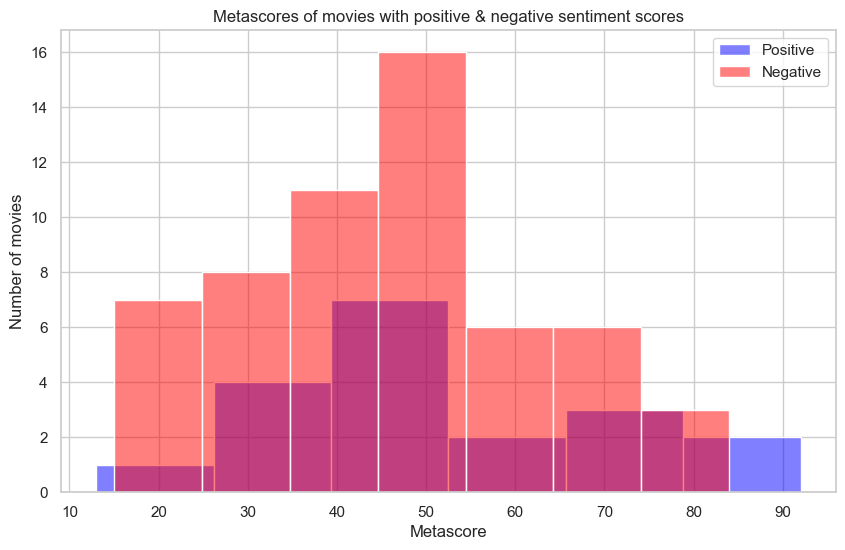

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter happy and sad movies based on sentiment
happy_movies = joinDB[joinDB['sentiment'] > 1]['score']
sad_movies = joinDB[joinDB['sentiment'] < -1]['score']

# Create a histogram to compare the Metascores of positive and negative sentiment movies
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(happy_movies, color="blue", alpha=0.5, label="Positive")
sns.histplot(sad_movies, color="red", alpha=0.5, label="Negative")
plt.title('Metascores of movies with positive & negative sentiment scores')
plt.xlabel('Metascore')
plt.ylabel('Number of movies')
plt.legend(loc='upper right')
plt.show()

The question being answered here is "Do happy movies movies score better than sad movies?" Suprisingly, it is quite the opposite. Using our sentiment data and the metascores, we created a histogram to understand the correlation between the two. We also need to point out that this data pretains to movies released in the year 2001. We could possibly be seeing this as most of the movies released in that year were sad. We will use the following graph to figure out the average metacores of both positive and negative sentiment movies to have a better grasp on this situation.

C:\Users\musta\AppData\Local\Temp\ipykernel_27788\4171111076.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Positive Sentiment", "Negative Sentiment"], y=[average_metascore_happy, average_metascore_sad], palette="viridis")


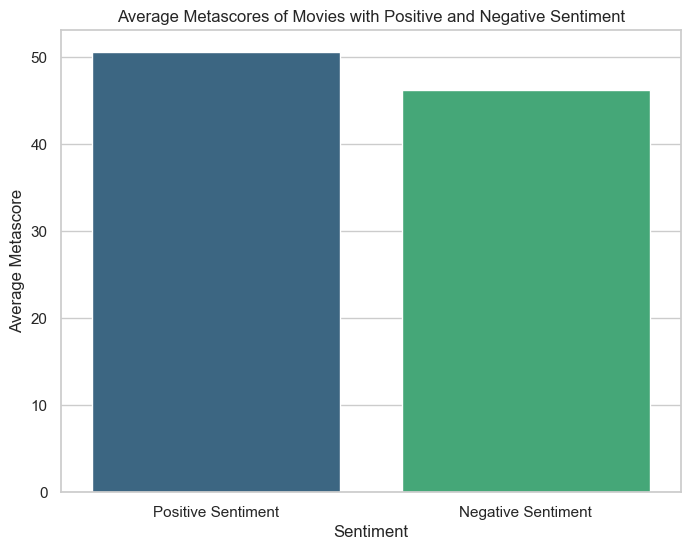

In [18]:
# Calculate the average Metascore for each group
average_metascore_happy = happy_movies.mean()
average_metascore_sad = sad_movies.mean()

# Create a bar plot to compare the average Metascores
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x=["Positive Sentiment", "Negative Sentiment"], y=[average_metascore_happy, average_metascore_sad], palette="viridis")
plt.title("Average Metascores of Movies with Positive and Negative Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Metascore")
plt.show()

Notably, I have observed that films exhibiting a positive sentiment tend to exhibit a higher average metascore in contrast to those with a negative sentiment. The primary rationale behind this phenomenon becomes evident as movies characterized by a positive sentiment generally possess metascores that surpass those associated with movies featuring a negative sentiment.